# Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date

from pprint import pprint
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split



import pickle
import time

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Scraping From Main Steam Search Page
Able to Scrape:
   1. Game Title (*DataFrame Index*)
   2. Systems that the game runs on
   3. Release date of game in days
   4. Discount by numerical percent
   5. Price of Game
   6. Number of Reviews (**Dependent Variable**)

## Helper Functions
Function for parsing date elements in dataset

In [2]:
def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

Function for creating list of links to parse

In [3]:
links=['https://store.steampowered.com/search/']
for i in range(1,1954):
    links.append('https://store.steampowered.com/search/?page='+str(i))

## The Scrape

In [ ]:
# cols = ['title', 'link', 'system', 'systems', 'reviews', 'release_date', 'discount', 'price']
# df=pd.DataFrame(columns=cols, index=[])

# age=date.today()
# for link in links:
#     response=requests.get(link)
#     soup = BeautifulSoup(response.text, 'html5lib')
#     try: 
#         main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
#     except:
#         time.sleep(20)
#         main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
#     print(link)
#     for game in main_search_table.find_all('a'):
#         row={}
#         row['title']=game.find('span', class_="title").text #title
#         row['link']=game['href'] #link
#         systems=[system["class"][1] for system in game.find('p').find_all('span')] #system
#         row['system']=len(systems)
#         row['systems']=systems
#         try:
#             row['release_date']=(age-(to_date(game.find('div', class_="col search_released responsive_secondrow").text).date())).days #release date  
#         except:
#             row['release_date']=0
#         for price in game.find_all('div', class_="col search_price_discount_combined responsive_secondrow"): #price and discount
#             for discount in price.find_all('div', class_="col search_discount responsive_secondrow"):
#                 if discount.find('span'):
#                     row['discount']=abs(int(discount.find('span').text.strip('%')))
#                     try:
#                         row['price']=float(price.find('span', style="color: #888888;").text.strip("$"))
#                     except:
#                         price = re.sub('[^0-9,.]','', game.find('div', class_="col search_price responsive_secondrow").text).replace("\n","").strip("\t")
#                         row['price']=price
#                 else:
#                     row['discount']=0
#                     if not game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t"):
#                         row['price']=0
#                     elif game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()[0]!='$': #'free to play' or game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()=='free':
#                         row['price']=0
#                     else:
#                         row['price']=float(game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").strip("$"))  
#         for y in game.find_all('div',class_="col search_reviewscore responsive_secondrow"):
#             x=[review['data-tooltip-html'] for review in y.find_all('span')]
#             if not x:
#                 row['reviews']=int(0)
#             else:
#                 z=x[0].split('<br>')
#                 d=z[1].split(" ")
#                 row['reviews']=int(d[3].replace(',', '')) #reviews
#         df=df.append(row, ignore_index=True)
#         with open('steam_search.pkl', 'wb') as picklefile:
#             pickle.dump(df, picklefile)
# #     time.sleep(3)
    
# df.set_index('title', inplace=True)
# df.rename(columns=lambda x: x.strip())
# pd.options.display.max_rows = 4000

Make copy of df from pickle and read into csv

In [ ]:
# with open("steam_search.pkl", 'rb') as picklefile: 
#       df2 = pickle.load(picklefile)
# df2.to_csv('steam3.csv')
# df2

Read in csv from previous scrape

In [4]:
df=pd.read_csv('steam3.csv')
len(df)

10475

### Remove Duplicates (if any)

In [5]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Modifying DataFrame Element Types to Support Regression

In [6]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)
#no_dup_df.info()

## Initial Analysis (IA): DataFrame Resulting From Main Page Scrape 
### 1. Initial Look at Relationships with Pairplots and Correlations

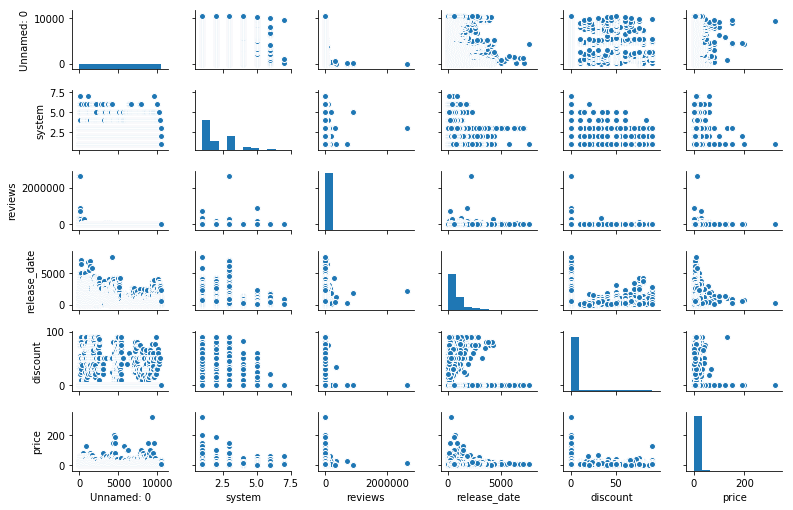

In [7]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [8]:
no_dup_df.corr()

,Unnamed: 0,system,reviews,release_date,discount,price
Unnamed: 0,1.000000,-0.083735,-0.085271,-0.352692,-0.078746,-0.228106
system,-0.083735,1.000000,0.029780,-0.066619,-0.042842,0.040310
reviews,-0.085271,0.029780,1.000000,0.052955,-0.001650,0.034856
release_date,-0.352692,-0.066619,0.052955,1.000000,-0.026548,0.058533
discount,-0.078746,-0.042842,-0.001650,-0.026548,1.000000,0.005490
price,-0.228106,0.040310,0.034856,0.058533,0.005490,1.000000


### 2. Split into Train/Test

In [9]:
y=no_dup_df['reviews']
X=no_dup_df.drop(['reviews'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

### 3. Run Patsy Regression

In [10]:
y_train, X_train = patsy.dmatrices('reviews ~ system + price + release_date + discount', data=traindf)
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                reviews   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     9.204
Date:                Tue, 17 Jul 2018   Prob (F-statistic):           2.05e-07
Time:                        19:55:24   Log-Likelihood:                -89512.
No. Observations:                7332   AIC:                         1.790e+05
Df Residuals:                    7327   BIC:                         1.791e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3904.6494   1346.266     -2.900      0.004   -6543.717   -1265.581
system        1515.4243    510.368      2.969      0.003     514.956    2515.893
price          126.0437     51.363      2.454      0.014      25.357     226.731
release_date     3.2421      0.693      4.676      0.000       1.883       4.601
discount        -2.8518     45.467     -0.063      0.950     -91.979      86.276
==============================================================================
Omnibus:                    22381.954   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1706818355.136
Skew:                          45.750   Prob(JB):                         0.00
Kurtosis:                    2364.905   Cond. No.                     2.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. 10 Fold Cross-Validation

In [11]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='mean_squared_error')
print(-scores)

[1.94056566e+09 9.42493111e+09 1.00890141e+10 3.65794238e+08
 2.56287777e+07 1.19455675e+09 2.39453626e+08 1.19235106e+08
 7.89315856e+07 6.78449615e+07]


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

### Additional Step: Run LassoCV on Initial Dataframe

## Feature Engineering and General DataFrame Mods

### 1. Modify DF to Account for Skew by Logging Reviews; Repeat IA

In [12]:
no_dup_df['log_reviews'] = np.log(no_dup_df.reviews + 1)
#plt.hist(no_dup_df['log_reviews'])

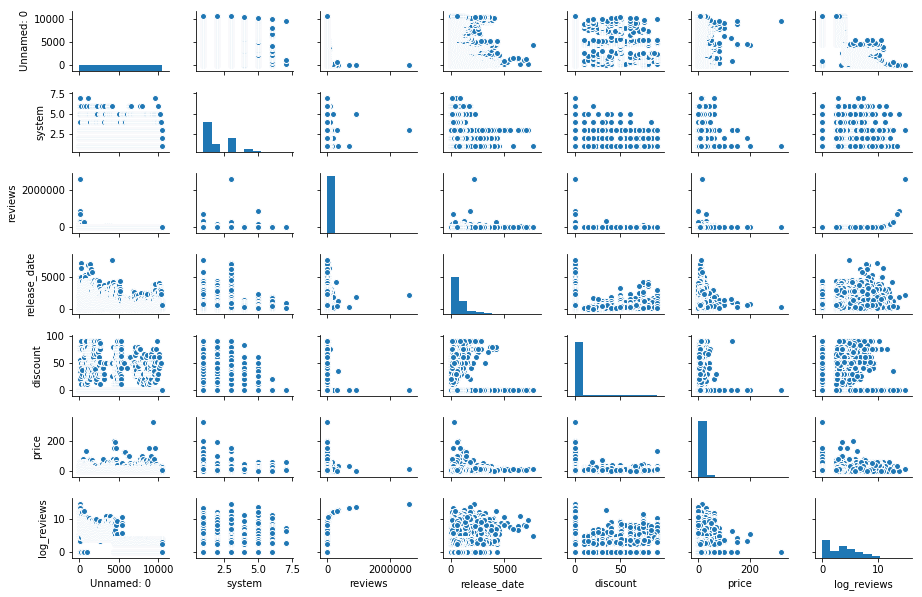

In [13]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [14]:
no_dup_df.corr()

,Unnamed: 0,system,reviews,release_date,discount,price,log_reviews
Unnamed: 0,1.000000,-0.083735,-0.085271,-0.352692,-0.078746,-0.228106,-0.746225
system,-0.083735,1.000000,0.029780,-0.066619,-0.042842,0.040310,0.111262
reviews,-0.085271,0.029780,1.000000,0.052955,-0.001650,0.034856,0.154937
release_date,-0.352692,-0.066619,0.052955,1.000000,-0.026548,0.058533,0.414833
discount,-0.078746,-0.042842,-0.001650,-0.026548,1.000000,0.005490,0.019260
price,-0.228106,0.040310,0.034856,0.058533,0.005490,1.000000,0.253827
log_reviews,-0.746225,0.111262,0.154937,0.414833,0.019260,0.253827,1.000000


In [15]:
y=no_dup_df['log_reviews']
X=no_dup_df.drop(['log_reviews','reviews'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

In [16]:
y_train, X_train = patsy.dmatrices('log_reviews ~ system + price + release_date + discount', data=traindf)
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     582.7
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:55:46   Log-Likelihood:                -17157.
No. Observations:                7332   AIC:                         3.432e+04
Df Residuals:                    7327   BIC:                         3.436e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1379      0.070     16.324      0.000       1.001       1.275
system           0.3402      0.026     12.903      0.000       0.289       0.392
price            0.0612      0.003     22.490      0.000       0.056       0.067
release_date     0.0014   3.54e-05     39.705      0.000       0.001       0.001
discount         0.0089      0.002      3.785      0.000       0.004       0.014
==============================================================================
Omnibus:                       95.329   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.887
Skew:                           0.118   Prob(JB):                     1.72e-33
Kurtosis:                       3.662   Cond. No.                     2.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='mean_squared_error')
print(-scores)

[6.19875655 6.6720967  5.95385873 6.15171711 6.38364968 6.17157504
 6.96815908 6.43661228 6.29954627 6.18360193]


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

### 2. Seperate Windows/Mac/Linux into Individual Bool 0/1 Columns; Repeat IA

In [18]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [19]:
no_dup_df['windows']=pd.Series(windows)
no_dup_df['mac']=pd.Series(mac)
no_dup_df['linux']=pd.Series(linux)

In [20]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

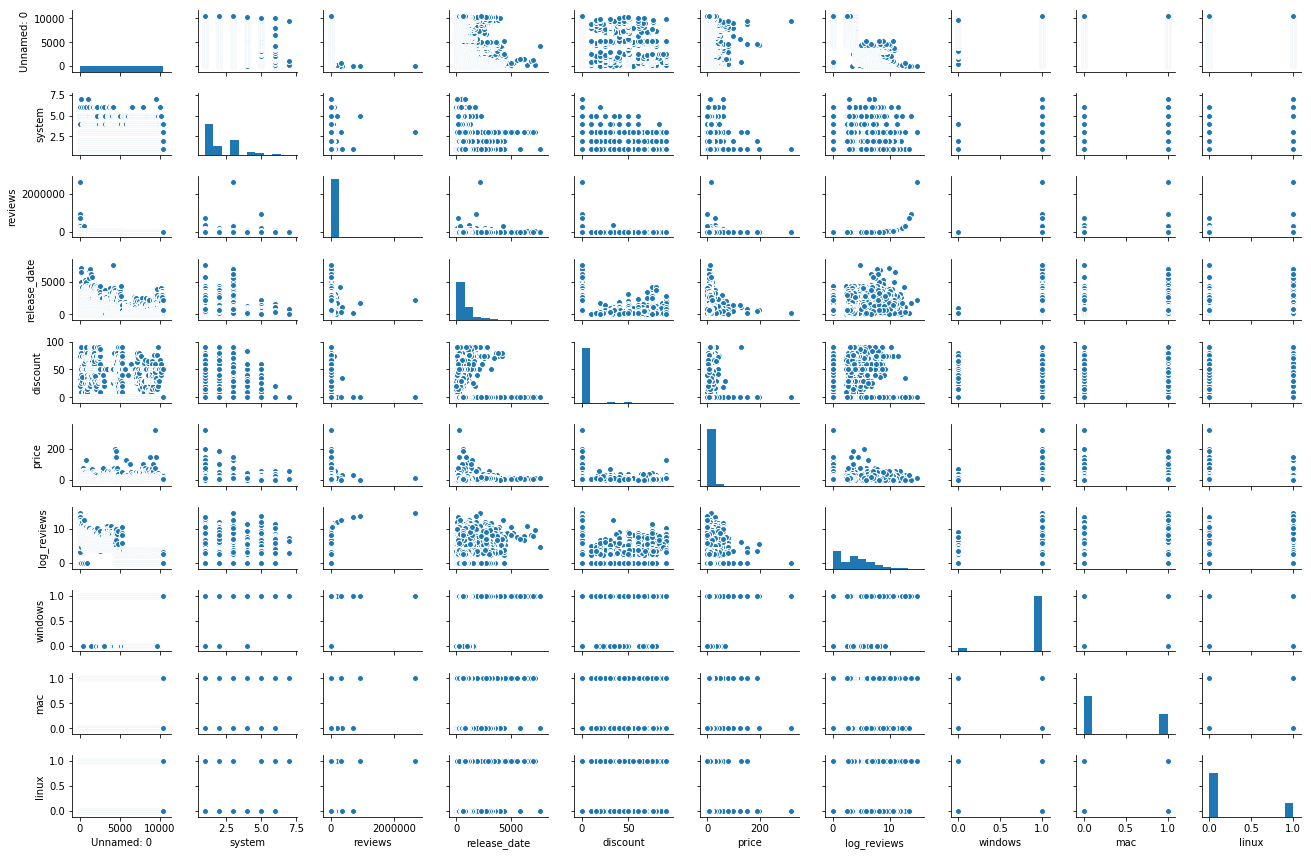

In [21]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [22]:
no_dup_df.corr()

,Unnamed: 0,system,reviews,release_date,discount,price,log_reviews,windows,mac,linux
Unnamed: 0,1.000000,-0.083735,-0.085271,-0.352692,-0.078746,-0.228106,-0.746225,-0.116022,-0.175435,-0.167806
system,-0.083735,1.000000,0.029780,-0.066619,-0.042842,0.040310,0.111262,0.189016,0.513661,0.543490
reviews,-0.085271,0.029780,1.000000,0.052955,-0.001650,0.034856,0.154937,0.013021,0.034906,0.044861
release_date,-0.352692,-0.066619,0.052955,1.000000,-0.026548,0.058533,0.414833,0.043331,0.085830,0.063673
discount,-0.078746,-0.042842,-0.001650,-0.026548,1.000000,0.005490,0.019260,-0.081144,-0.007856,-0.007045
price,-0.228106,0.040310,0.034856,0.058533,0.005490,1.000000,0.253827,0.039636,0.012236,0.014199
log_reviews,-0.746225,0.111262,0.154937,0.414833,0.019260,0.253827,1.000000,0.201263,0.228516,0.216793
windows,-0.116022,0.189016,0.013021,0.043331,-0.081144,0.039636,0.201263,1.000000,0.177690,0.136032
mac,-0.175435,0.513661,0.034906,0.085830,-0.007856,0.012236,0.228516,0.177690,1.000000,0.669413
linux,-0.167806,0.543490,0.044861,0.063673,-0.007045,0.014199,0.216793,0.136032,0.669413,1.000000


In [23]:
y=no_dup_df['log_reviews']
X=no_dup_df.drop(['log_reviews','reviews'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

In [24]:
y_train, X_train = patsy.dmatrices('log_reviews ~ system + price + release_date + discount + windows + mac + linux', data=traindf)
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     447.5
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:56:12   Log-Likelihood:                -16845.
No. Observations:                7332   AIC:                         3.371e+04
Df Residuals:                    7324   BIC:                         3.376e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3981      0.127     -3.140      0.002      -0.647      -0.150
system          -0.0233      0.032     -0.730      0.465      -0.086       0.039
price            0.0675      0.003     23.950      0.000       0.062       0.073
release_date     0.0013   3.45e-05     38.112      0.000       0.001       0.001
discount         0.0089      0.002      3.877      0.000       0.004       0.013
windows          1.9780      0.124     16.005      0.000       1.736       2.220
mac              0.6546      0.082      8.012      0.000       0.494       0.815
linux            0.6587      0.092      7.153      0.000       0.478       0.839
==============================================================================
Omnibus:                       41.662   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.116
Skew:                           0.114   Prob(JB):                     1.31e-11
Kurtosis:                       3.334   Cond. No.                     6.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='mean_squared_error')
print(-scores)

[5.93300486 5.4021023  5.62210691 5.91541927 5.6508476  6.57839305
 5.98329072 5.18107445 5.93134223 5.93911568]


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

### 3. Drop Movies;

In [26]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])
no_dup_df.set_index('title', inplace=True)
del(no_dup_df['Unnamed: 0'])

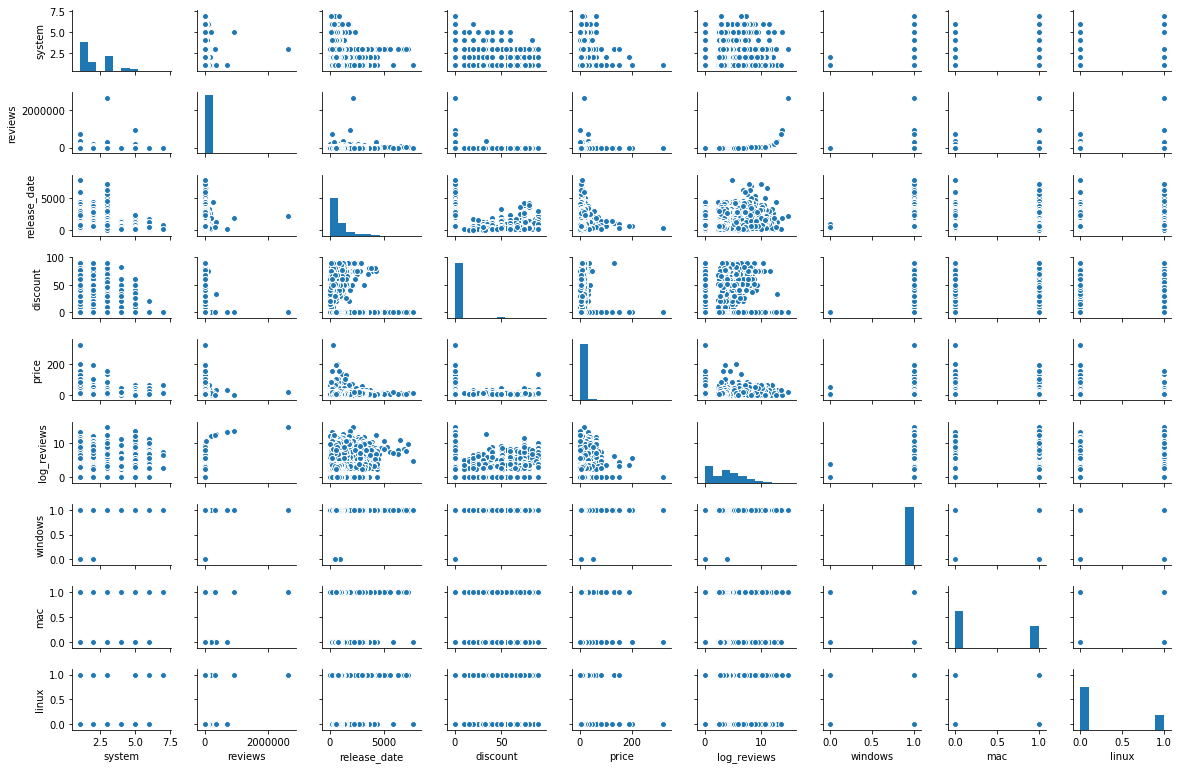

In [27]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [28]:
no_dup_df.corr()

,system,reviews,release_date,discount,price,log_reviews,windows,mac,linux
system,1.000000,0.027918,-0.075770,-0.028514,0.035402,0.078330,0.012625,0.498125,0.533470
reviews,0.027918,1.000000,0.052645,-0.000571,0.035113,0.157202,0.001130,0.033123,0.043488
release_date,-0.075770,0.052645,1.000000,-0.013303,0.063006,0.418444,0.002071,0.079754,0.058523
discount,-0.028514,-0.000571,-0.013303,1.000000,-0.027170,0.038989,0.004231,0.007197,0.004519
price,0.035402,0.035113,0.063006,-0.027170,1.000000,0.260278,-0.008404,0.005189,0.008863
log_reviews,0.078330,0.157202,0.418444,0.038989,0.260278,1.000000,0.018658,0.202341,0.197226
windows,0.012625,0.001130,0.002071,0.004231,-0.008404,0.018658,1.000000,-0.005383,-0.022584
mac,0.498125,0.033123,0.079754,0.007197,0.005189,0.202341,-0.005383,1.000000,0.661591
linux,0.533470,0.043488,0.058523,0.004519,0.008863,0.197226,-0.022584,0.661591,1.000000


In [29]:
y=no_dup_df['log_reviews']
X=no_dup_df.drop(['log_reviews','reviews'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

In [30]:
y_train, X_train = patsy.dmatrices('log_reviews ~ system + price + release_date + discount + windows + mac + linux', data=traindf)
model = sm.OLS(y_train, X_train)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_reviews   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     466.6
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        19:57:01   Log-Likelihood:                -21628.
No. Observations:                9383   AIC:                         4.327e+04
Df Residuals:                    9375   BIC:                         4.333e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.0669      1.717     -1.786      0.074      -6.433       0.299
system           0.0332      0.027      1.246      0.213      -0.019       0.086
price            0.0622      0.002     26.328      0.000       0.058       0.067
release_date     0.0013   3.12e-05     42.427      0.000       0.001       0.001
discount         0.0139      0.002      6.056      0.000       0.009       0.018
windows          4.4919      1.717      2.616      0.009       1.126       7.857
mac              0.4377      0.072      6.077      0.000       0.297       0.579
linux            0.7471      0.082      9.160      0.000       0.587       0.907
==============================================================================
Omnibus:                      145.187   Durbin-Watson:                   1.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.430
Skew:                           0.079   Prob(JB):                     1.40e-58
Kurtosis:                       3.810   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='mean_squared_error')
print(-scores)

[5.26601967 6.53223734 6.10014076 5.41168974 6.47379876 5.60581007
 5.76974032 5.86571382 5.97332138 6.2440566 ]


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  s

# Scraping from Individual Game Pages
Available data:
    1. Genre
    2. Single/Multiplayer
    3. Number of Languages
    4. Developer
    5. Publisher
    6. User-defined tages
    7. Release date (repeat)
    8. Recent Updates
    9. System Requirements

## The Scrape

In [ ]:
'''
cols2 = ['title', 'developer', 'user_tags', 'languages', 'genres', 'specs']
df_gamepg=pd.DataFrame(columns=cols2, index=[])
link_games=list(no_dup_df.link)

for link in link_games[0:15]:
    try:
        response=requests.get(link)
        soup = BeautifulSoup(response.text, 'html5lib')
        row1={}
        row1['title']=soup.find('div', class_='apphub_AppName').text
        for developers in soup.find_all('div', class_="summary column", id="developers_list"):
            developer=[one_developer.text for one_developer in developers.find_all('a')]
        row1['developer']=developer
        user_tags=[tag.text.replace("\n","").strip("\t") for tag in soup.find_all('a', class_="app_tag")]
        row1['user_tags']=user_tags
        all_lang=[]
        for languages in soup.find_all('table', class_="game_language_options"):
            for element in languages.find_all('tr', style=True, class_=True):
                language=(element.find('td', class_="ellipsis").text.replace("\n","").strip("\t"))
                options=[language if bool(options.text.replace("\n","").strip("\t")) else 0 for options in element.find_all('td', class_="checkcol")]
                all_lang.append(tuple(options))
        row1['languages']=all_lang
        x=soup.find_all('div', class_="details_block")[0].text.replace("\n","").split("\t")
        feature_list = list(filter(None, x))
        y=feature_list[1].split(":")
        genres=y[1]
        row1['genres']=genres
        specs=[]
        for element in soup.find_all('div', class_="game_area_details_specs"):
            l=[]
            for e2 in element.find_all('a'):
                l.append(e2.text.replace("\n","").strip("\t"))
            specs.extend(l)
        full_specs=list(filter(None, specs))
        row1['specs']=full_specs 
        df_gamepg=df_gamepg.append(row1, ignore_index=True)
    except:
        print(link)
df_gamepg.set_index('title', inplace=True)
df_gamepg.rename(columns=lambda x: x.strip())
pd.options.display.max_rows = 4000
df_gamepg
'''

In [ ]:
df

In [ ]:
df_gamepg

In [ ]:
no_dup_df

In [ ]:
no_dup_gamepg_df